In [1]:
import pyabf
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from os import getcwd,listdir
import csv

# Function

## Version 2

In [2]:
def analysis_Bias(abf,volt,start_single,end_single,timeStart=0, timeEnd = None):
    abf.setSweep(0,channel=4)
    bias = np.digitize(abf.sweepY[timeStart:timeEnd],bins = [volt])
    if volt<100:
        bias = 1-bias
    close_index = []
    far_index = []
    index = []
    debug = False #When debugging, set debug to True

    # Solving starting with a single far point problem
    if start_single:
        close_flag = False
    else:
        close_flag = True
        
    for i in range(0,len(bias)-1):
        dif = bias[i+1]-bias[i]
        
        #只需考慮bias差值小於-1的部分（下降點）
        #另外應該從volt點下降，10是寬限，比方説800mv，則下降應從於700mv
        '''
        if dif<-1 and bias[i]>volt-95 and bias[i+1]<volt-95: 
            f = False
            for gap in range(5):
                if i+gap < len(bias):
                    if bias[i+gap]<volt-95:
                        f = True
                        break
            if f == False:
                break
            '''
        if dif == -1:
            index.append(i)
            if close_flag:
                close_index.append(i)
                close_flag = False
            else:
                far_index.append(i)
                close_flag = True
    
    # Solve starting and/or ending with a single far point problem
    if start_single:
        far_index = far_index[1:]
    if end_single:
        close_index = close_index[:-1]
    
    print("Close point found: "+str(len(close_index)))
    print("Far point found: "+str(len(far_index)))
    
    if debug:
        print("Close point are:")
        for i in close_index:
            print(abf.sweepX[timeStart:timeEnd][i],bias[i])

        print("Far point are:")
        for i in far_index:
            print(abf.sweepX[timeStart:timeEnd][i],bias[i])
    return index,close_index,far_index

In [3]:
def findStable_Bias(abf,volt,start_single=False,end_single=False,mean_range=5,timeStart = 0, timeEnd = None,channel = 2):
    index,close_index,far_index = analysis_Bias(abf,volt,start_single,end_single,timeStart = timeStart,timeEnd = timeEnd)
    
    # mean_range default set as 5 because 1ms = 5 data points
    abf.setSweep(0,channel=channel)
    close = []
    far = []

    for ci in close_index:
        t = abf.sweepY[timeStart:timeEnd][ci-4:ci+1]
        mean = np.mean(np.array(t))
        close.append(mean)
        
    for fi in far_index:
        t = abf.sweepY[timeStart:timeEnd][fi-4:fi+1]
        mean = np.mean(np.array(t))
        far.append(mean)
        
    return close,far,close_index,far_index

In [4]:
def print_points_qty(abf,index):
    x = []
    abf.setSweep(0,channel = 3)
    for c in index:
        x.append(abf.sweepY[c]) # Record X-axis value
    x = np.round(x,decimals = 0) # Round to bin
    newline = False
    lastx = -1
    C = []
    temp = []

    # Count the record qty according to X-axis
    for e in x:
        if lastx != e:
            if e>lastx:
                temp.append(1)
            else:
                C.append(temp)
                temp = [1]
        else:
            temp[-1]+=1
        lastx = e
    C.append(temp)

    for t in C:
        for n in t:
            print("%-2d"%n,end=' ')
        print()
    print("Total points: "+str(np.sum(C)))

In [5]:
def plot_v2(abf,volt,start_single=False,end_single=False,timeStart = 0, timeEnd = None,channel = 2):
    abf.setSweep(0,channel = channel)
    plt.figure(figsize=(18,5))
    plt.plot(abf.sweepX[timeStart:timeEnd],abf.sweepY[timeStart:timeEnd],color = 'green')
    
    #plot the stable 
    index,close_index,far_index = analysis_Bias(abf,volt,start_single,end_single,timeStart = timeStart,timeEnd = timeEnd)
    abf.setSweep(0,channel = channel)
    barX_start = []
    barY_start = []
    barX_end = []
    barY_end = []
    counting = 0
    for i in index:
        length = 21
        counting+=1
        for j in range(length):
            barX_end.append(abf.sweepX[timeStart:timeEnd][i])
            barY_end.append(abf.sweepY[timeStart:timeEnd][i]+(j-int(length/2)+1))
            barX_start.append(abf.sweepX[timeStart:timeEnd][i-4])
            barY_start.append(abf.sweepY[timeStart:timeEnd][i-4]+(j-int(length/2)+1))
        plt.annotate(str(counting),xy=(abf.sweepX[timeStart:timeEnd][i-4],abf.sweepY[timeStart:timeEnd][i-4]+(j-int(length/2)+1)+1))
    plt.scatter(barX_end,barY_end,s=1,facecolors='b', edgecolors='b')
    plt.scatter(barX_start,barY_start,s=1,facecolors='r',edgecolors='r')
    plt.ylabel(abf.sweepLabelY)
    plt.xlabel(abf.sweepLabelX)
    plt.show()
    return len(close_index),len(far_index)

Close point found: 9
Far point found: 9


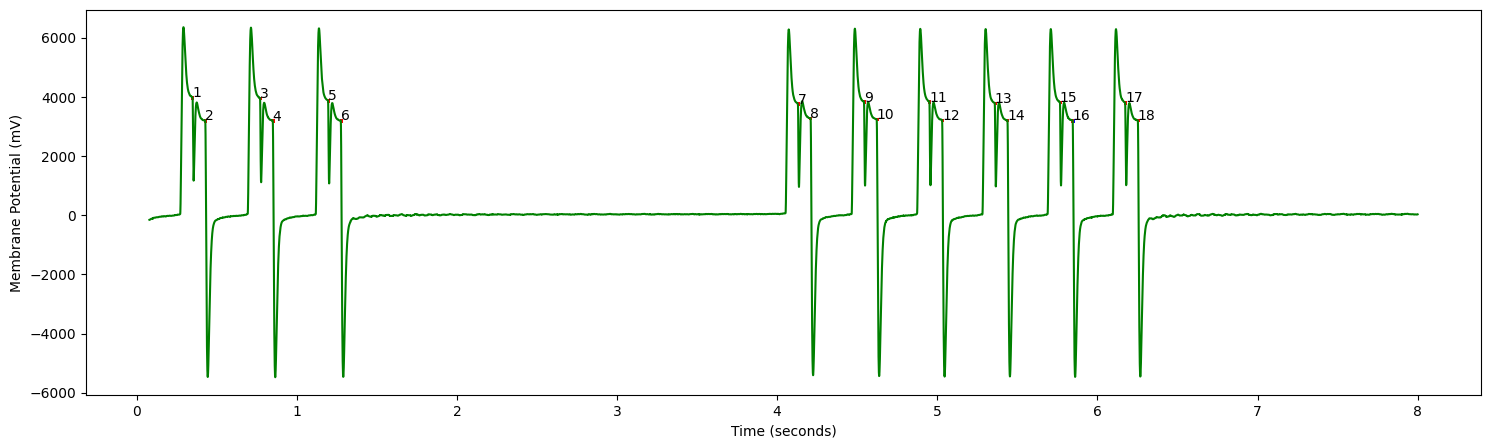

Close point found: 9
Far point found: 9


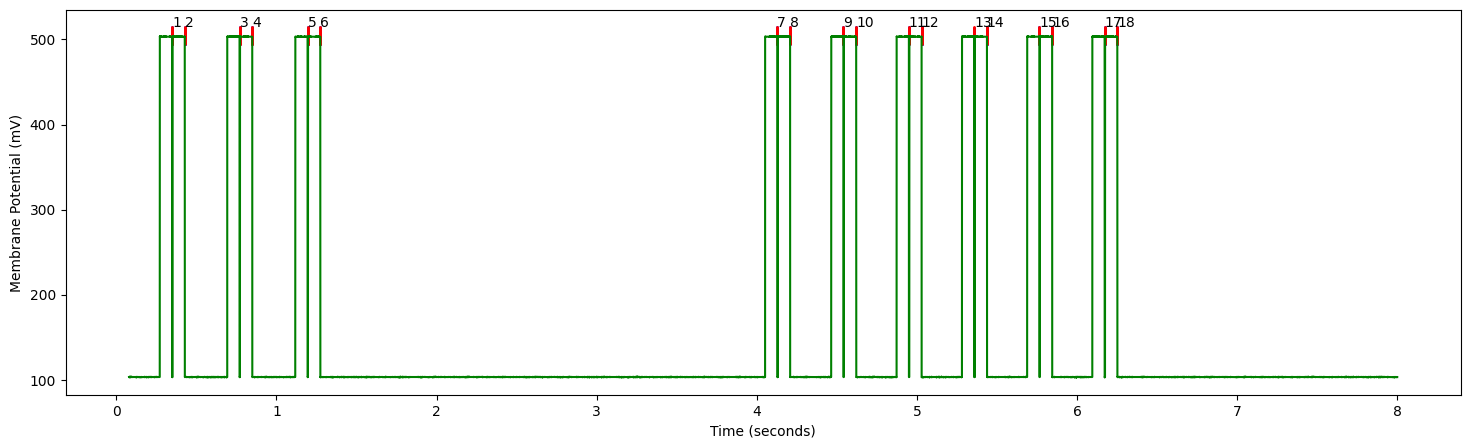

(9, 9)

In [6]:
#Test
abfFile = "23428006.abf"
abfFile2 = "23620010.abf"
volt_cut = 250
abf = pyabf.ABF("abf\\"+abfFile)
plot_v2(abf,volt_cut,timeStart = 2000,timeEnd = 200000,channel=2)
plot_v2(abf,volt_cut,timeStart = 2000,timeEnd = 200000,channel=4)

Close point found: 6
Far point found: 6


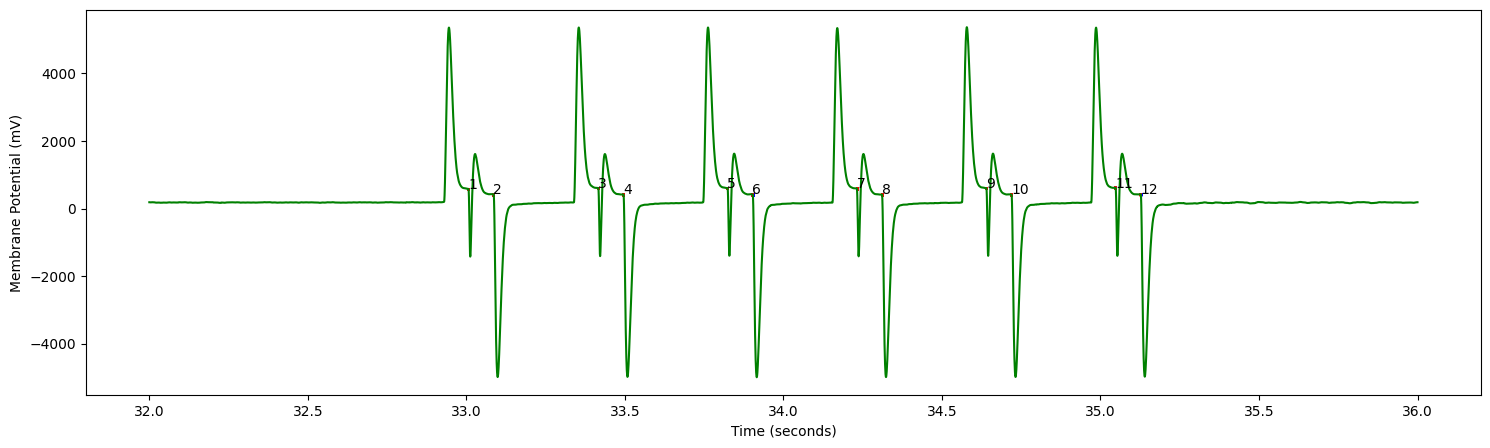

Close point found: 6
Far point found: 6


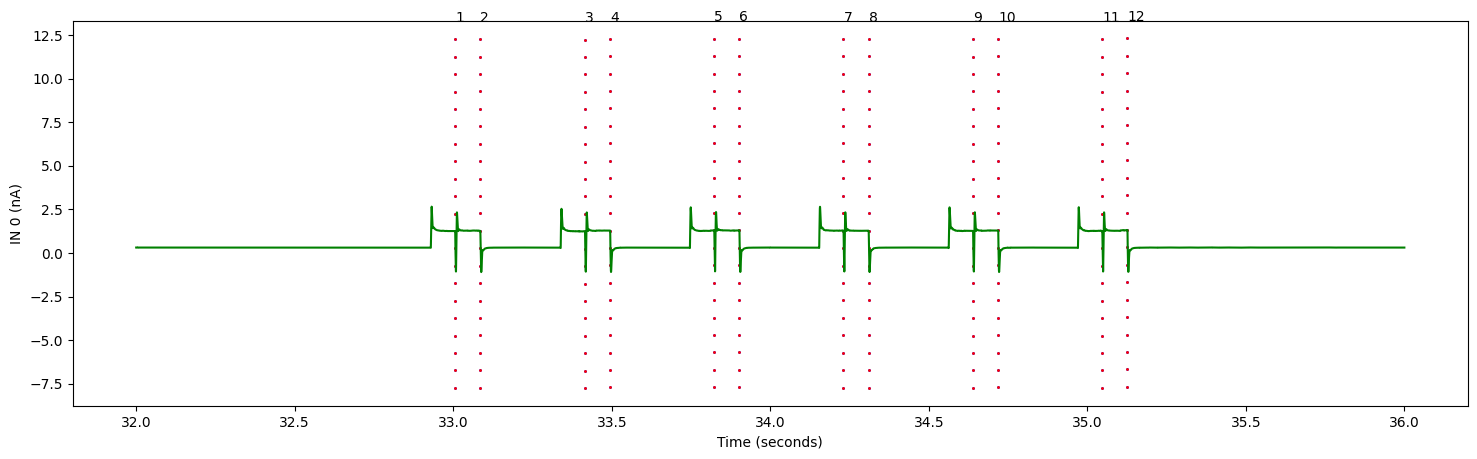

Close point found: 6
Far point found: 6


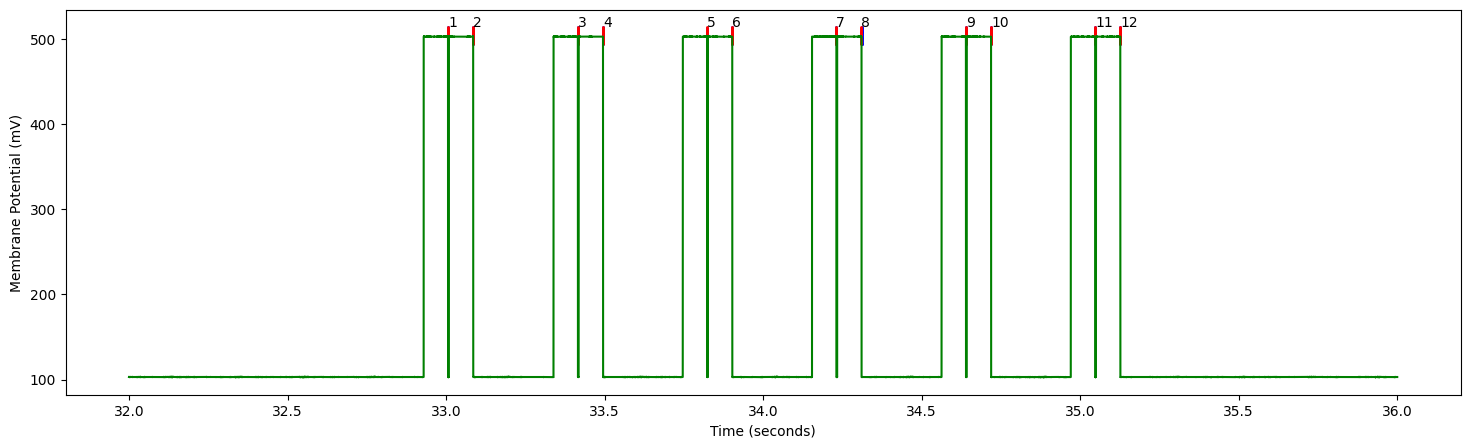

(6, 6)

In [7]:
abfFile = "23620010.abf"
volt_cut = 250
abf = pyabf.ABF("abf\\"+abfFile)
plot_v2(abf,volt_cut,timeStart = 800000,timeEnd = 900000,channel=2)
plot_v2(abf,volt_cut,timeStart = 800000,timeEnd = 900000,channel=0)
plot_v2(abf,volt_cut,timeStart = 800000,timeEnd = 900000,channel=4)

## Version 1

In [8]:
# Separate AUT and Quartz
def separate(arr,Row=50,Col=50,pqty = 25,start_ignore = 4,end_ignore = 0,start_extra = 5,end_extra = 0,bias = 0):
    # start_ignore and end_ignore: extra points before reshape into rows
    # start_extra and end_extra: extra points of each rows
    # Convert end_ignore
    if end_ignore == 0:
        end_ignore = None
    else:
        end_ignore = -end_ignore
        
    # Convert end_extra
    if end_extra == 0:
        end_extra = None
        end_num = 0
    else:
        end_extra = -end_extra
        end_num = end_extra
    
    # Ignore first row
    print(6*Col + start_ignore,end_ignore)
    arr = arr[6*Col + start_ignore:end_ignore]
    arr = np.reshape(arr,(Row-1,Col+start_extra-end_num))
    aut = np.array([])
    quartz = np.array([])
    for row in arr:
        aut = np.append(aut,row[start_extra:start_extra+pqty])
        quartz = np.append(quartz,row[-pqty+end_num:end_extra])
    return aut+bias,quartz+bias

In [9]:
def plot_colormap(data,title = "AUT and QUARTZ",path = ""):
    """
    Helper function to plot data with associated colormap.
    """
   # fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
    #                        constrained_layout=True, squeeze=False)
    figure, axes = plt.subplots(figsize=(data.shape[1]/5,data.shape[0]/5))
    psm = axes.pcolormesh(data, cmap='rainbow',rasterized=True)
    figure.colorbar(psm, ax=axes)
    axes.invert_yaxis()
    if abs(data.shape[1]-data.shape[0])<=1:
        print(data.shape[1],data.shape[0])
        axes.set_aspect('equal', adjustable='box')
    plt.title(title)
    plt.savefig(path+" "+title)
    plt.show()

# Test

## Test 01_v2 -- With start time and end time

Close point found: 1
Far point found: 1


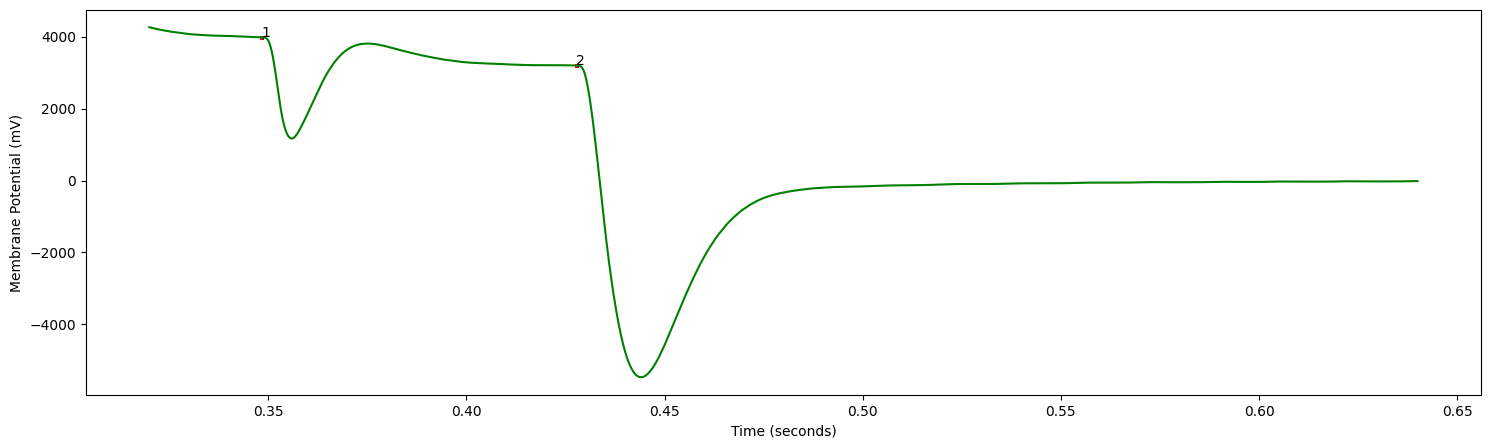

[4261.411  4260.4956 4259.58   ...  -16.2378  -15.9326  -15.6274]


In [33]:
timeStart = 8000
timeEnd = 16000
plot_v2(abf,volt_cut,timeStart = timeStart, timeEnd = timeEnd,channel=2)
print(abf.sweepY[timeStart:timeEnd])

## Test 02_v2 -- Check all graph

Time: 0 ~ 200050
Close point found: 11
Far point found: 10


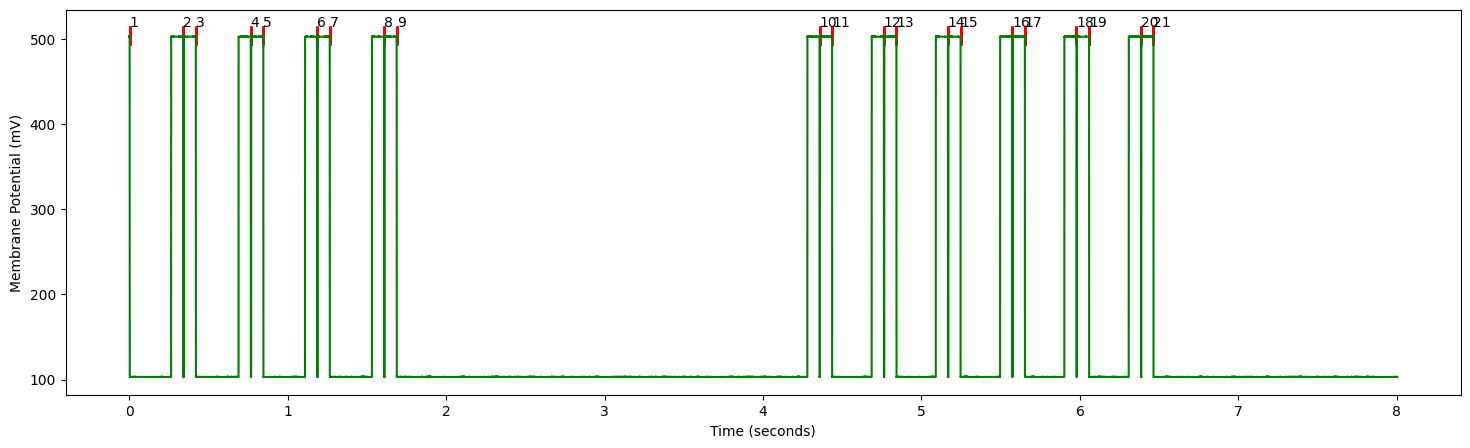

Time: 200000 ~ 400050
Close point found: 12
Far point found: 11


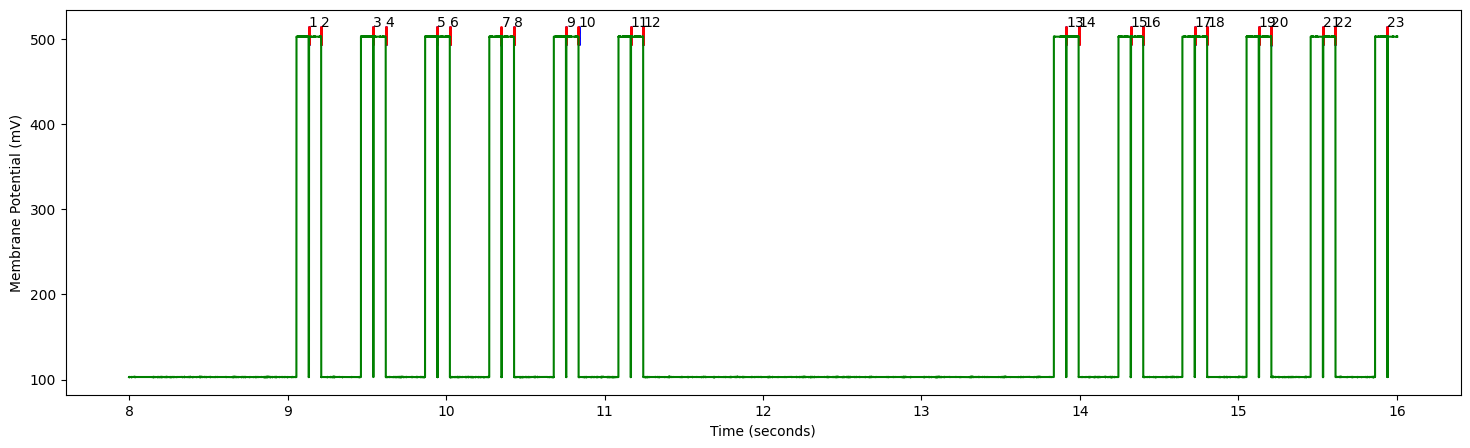

Time: 400000 ~ 600050
Close point found: 9
Far point found: 8


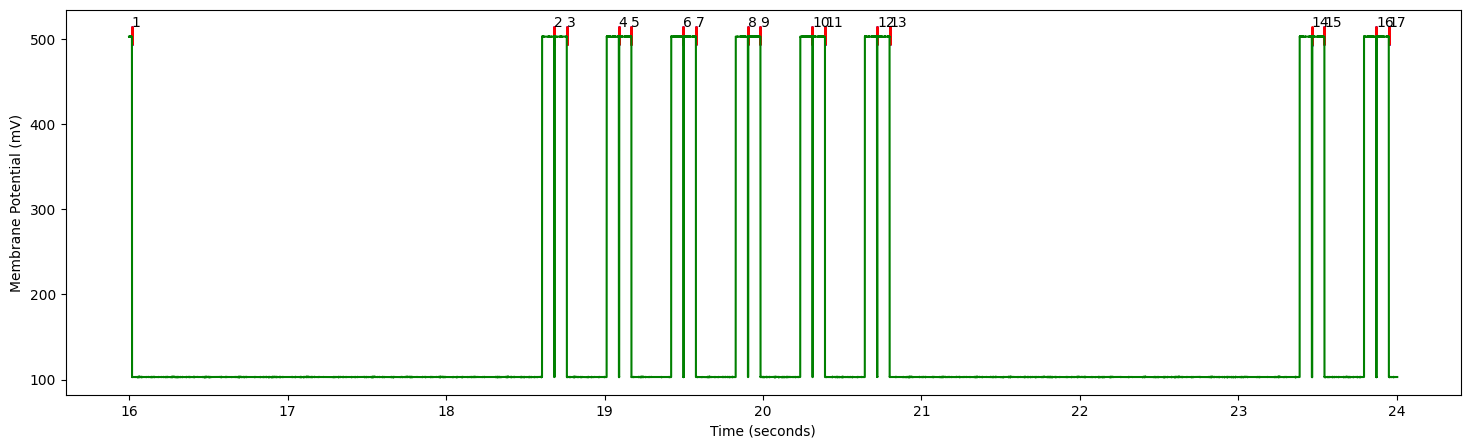

Time: 600000 ~ 800050
Close point found: 10
Far point found: 10


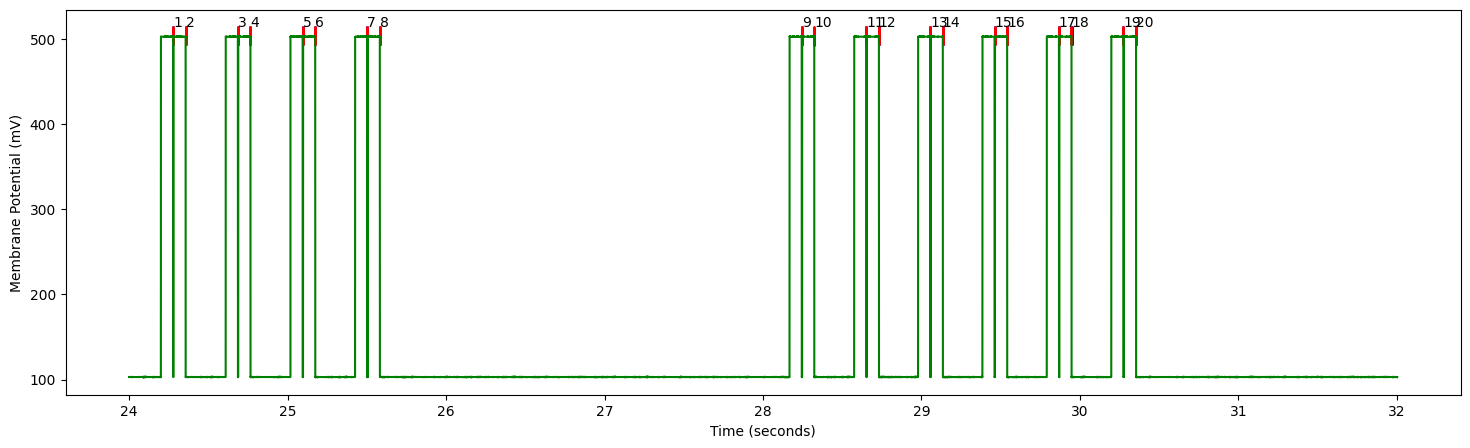

Time: 800000 ~ 1000050
Close point found: 12
Far point found: 12


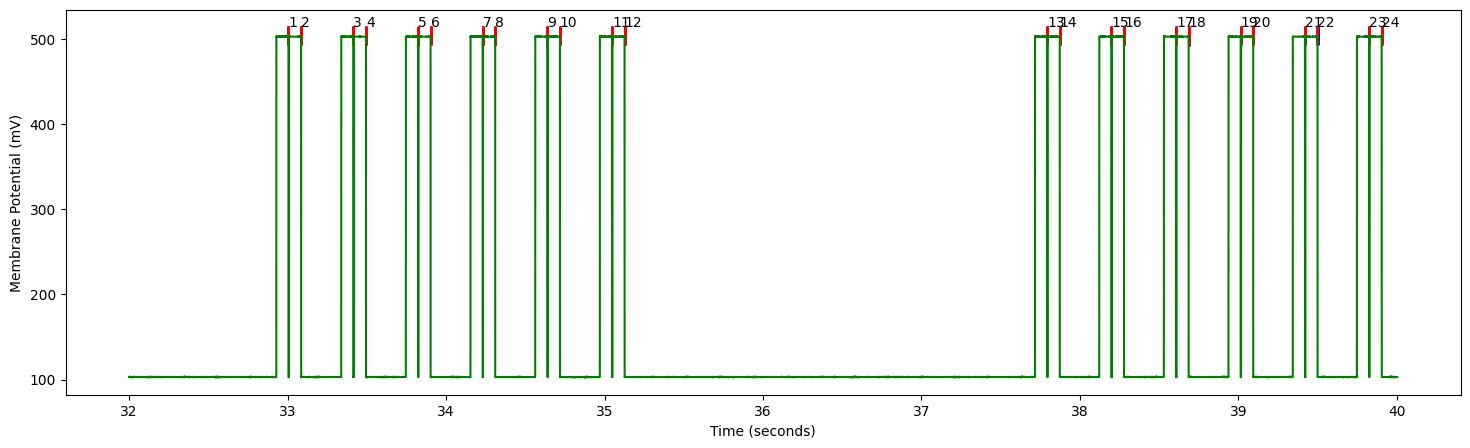

Time: 1000000 ~ 1200050
Close point found: 8
Far point found: 8


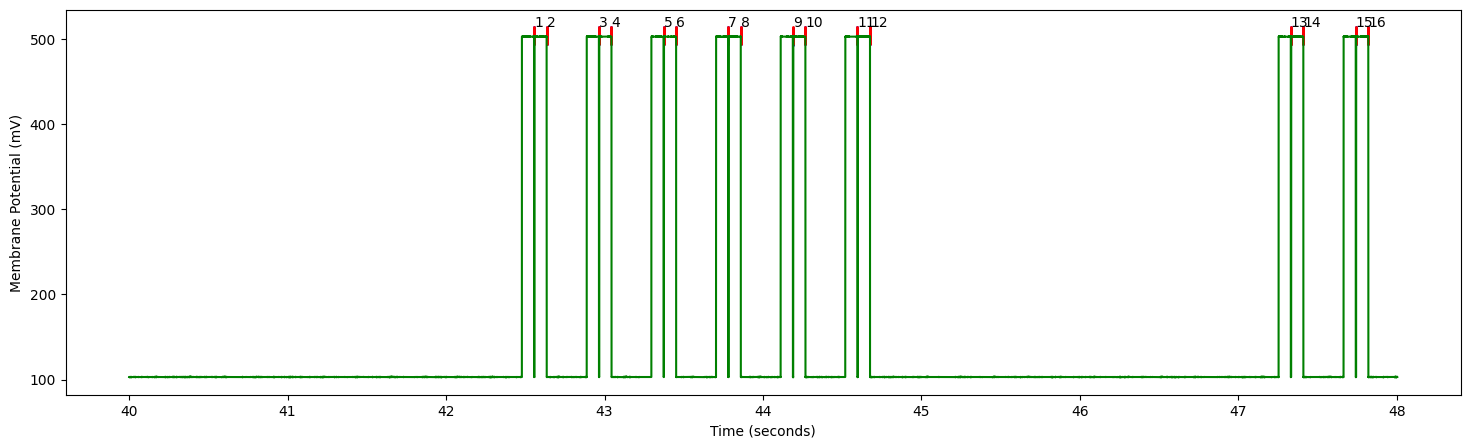

Time: 1200000 ~ 1400050
Close point found: 10
Far point found: 10


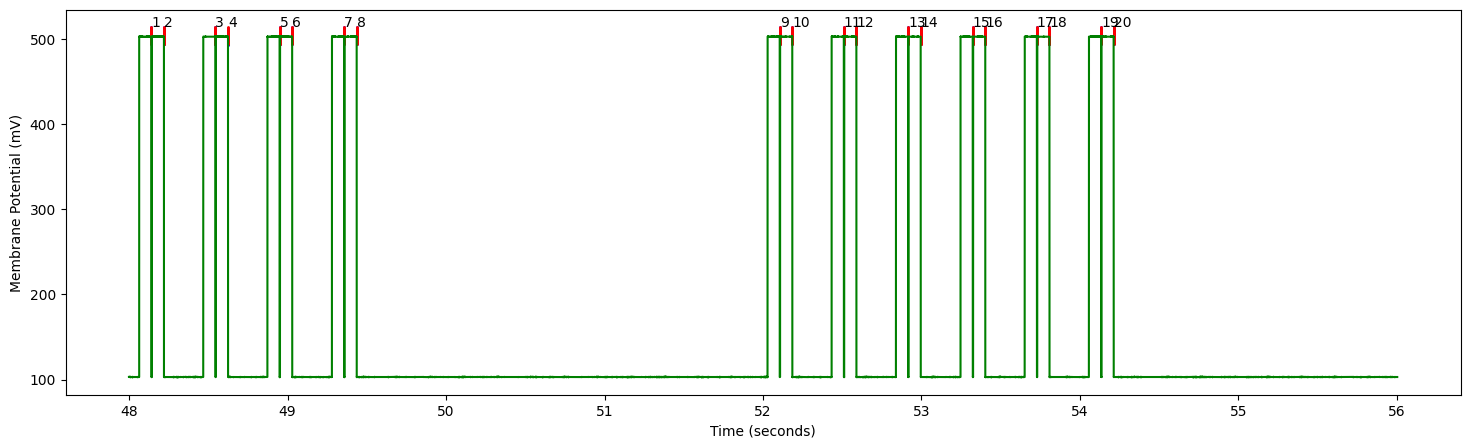

Time: 1400000 ~ 1600050
Close point found: 12
Far point found: 12


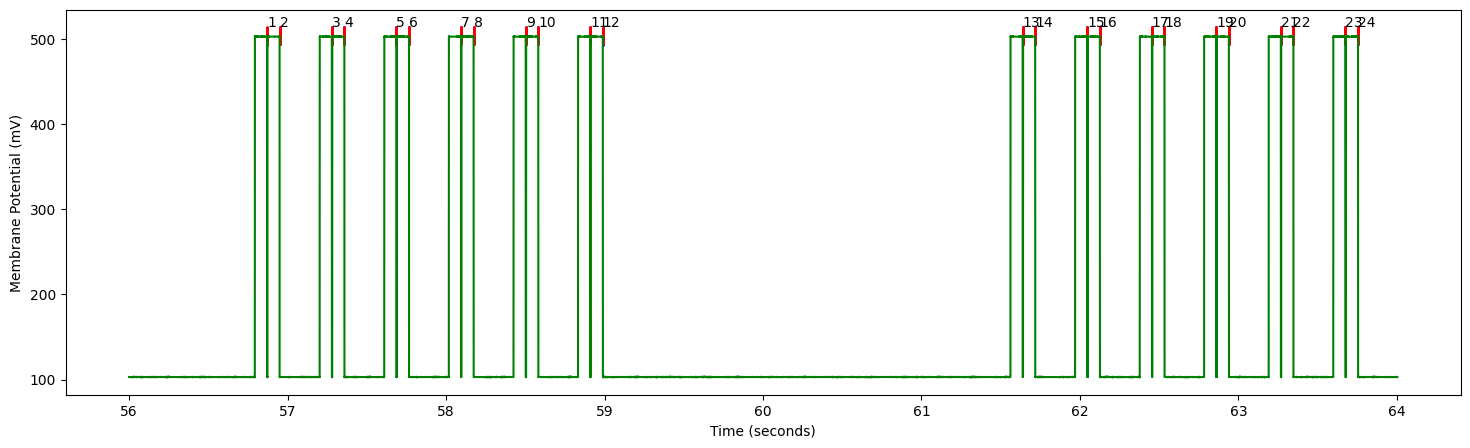

Time: 1600000 ~ 1800050
Close point found: 9
Far point found: 8


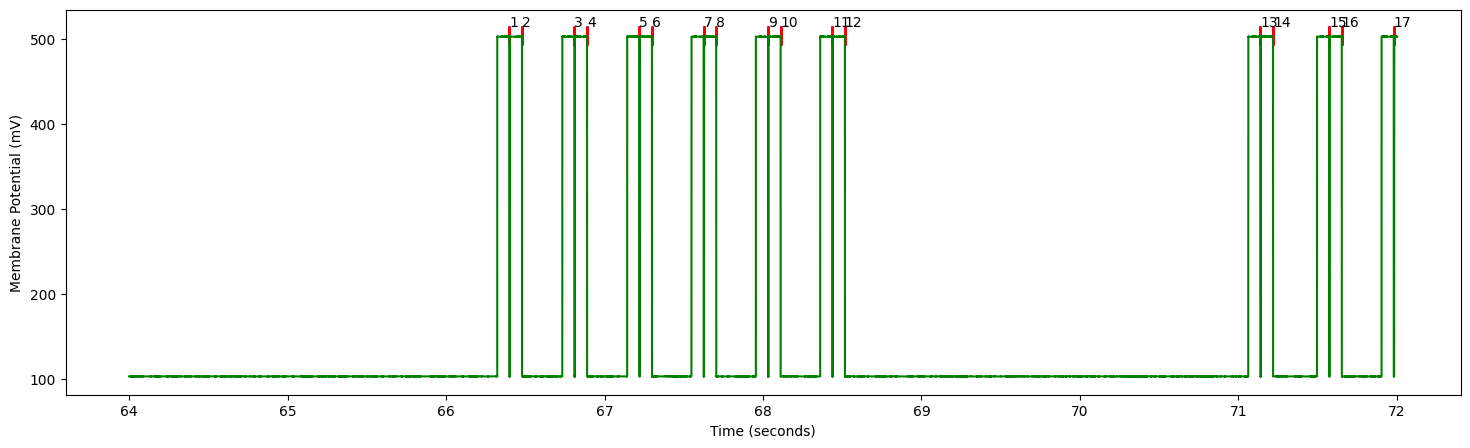

Time: 1800000 ~ 2000050
Close point found: 10
Far point found: 9


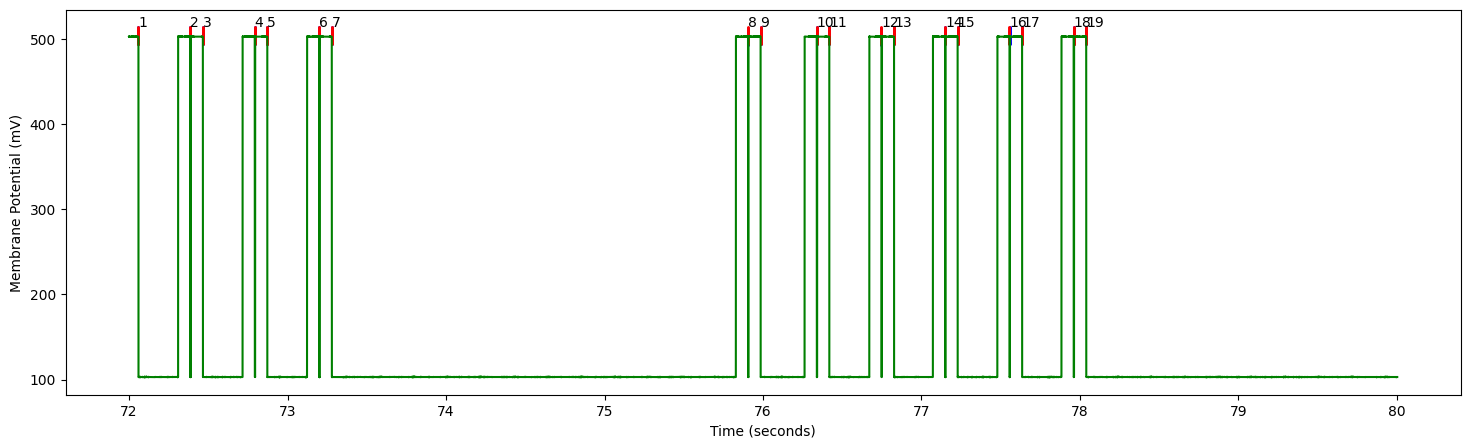

Time: 2000000 ~ 2200050
Close point found: 12
Far point found: 12


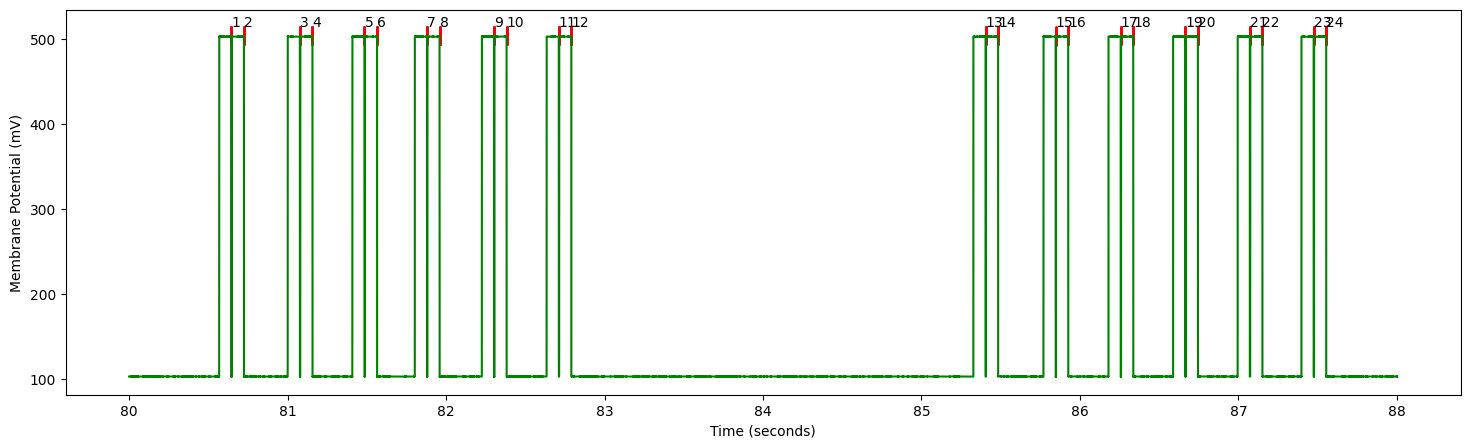

Time: 2200000 ~ 2400050
Close point found: 9
Far point found: 9


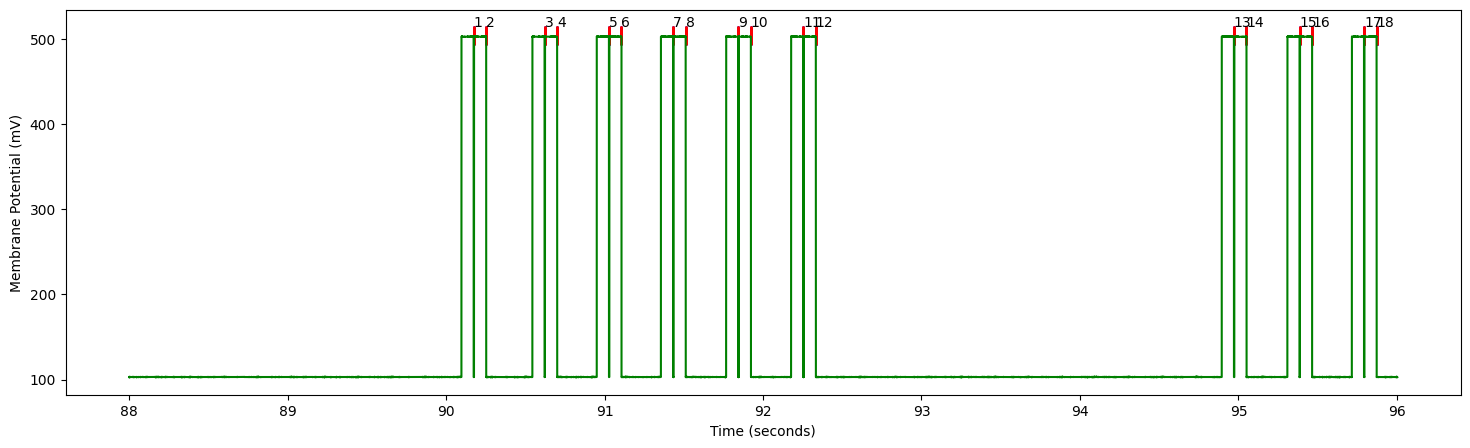

Time: 2400000 ~ 2600050
Close point found: 9
Far point found: 9


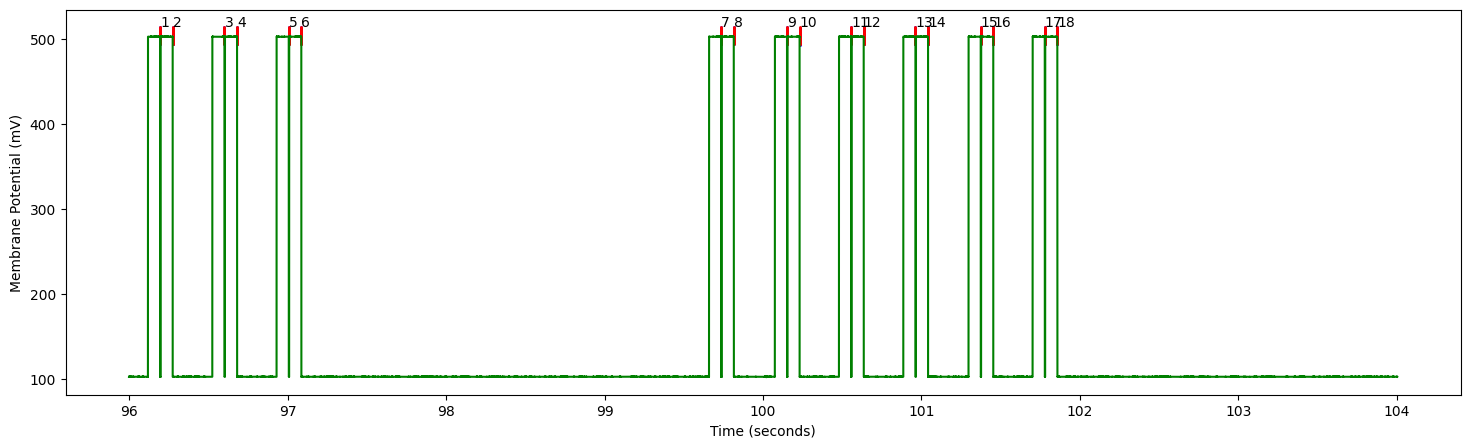

Time: 2600000 ~ 2800050
Close point found: 12
Far point found: 12


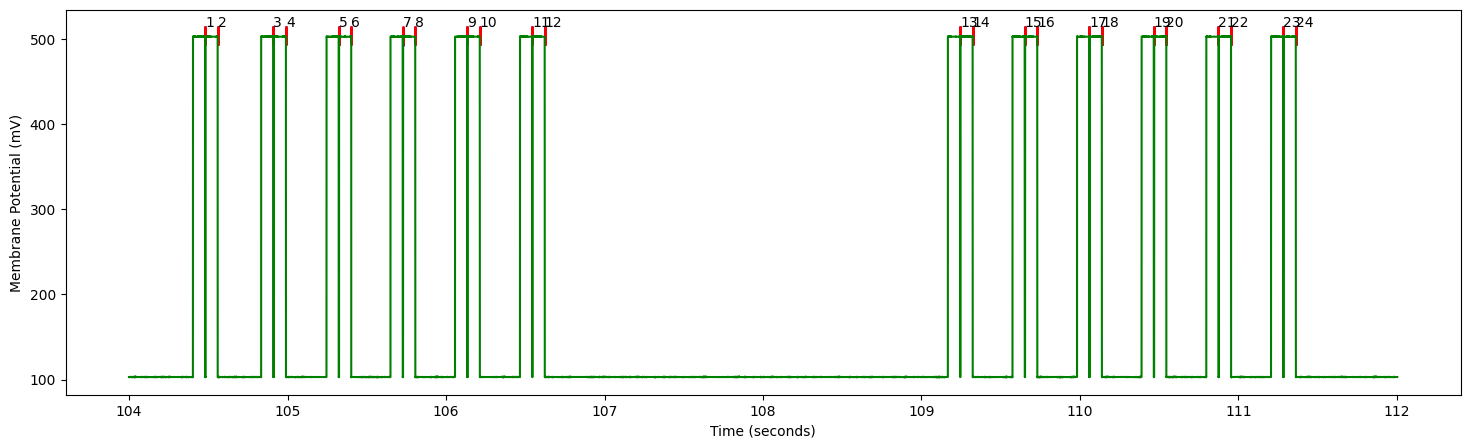

Time: 2800000 ~ 3000050
Close point found: 10
Far point found: 9


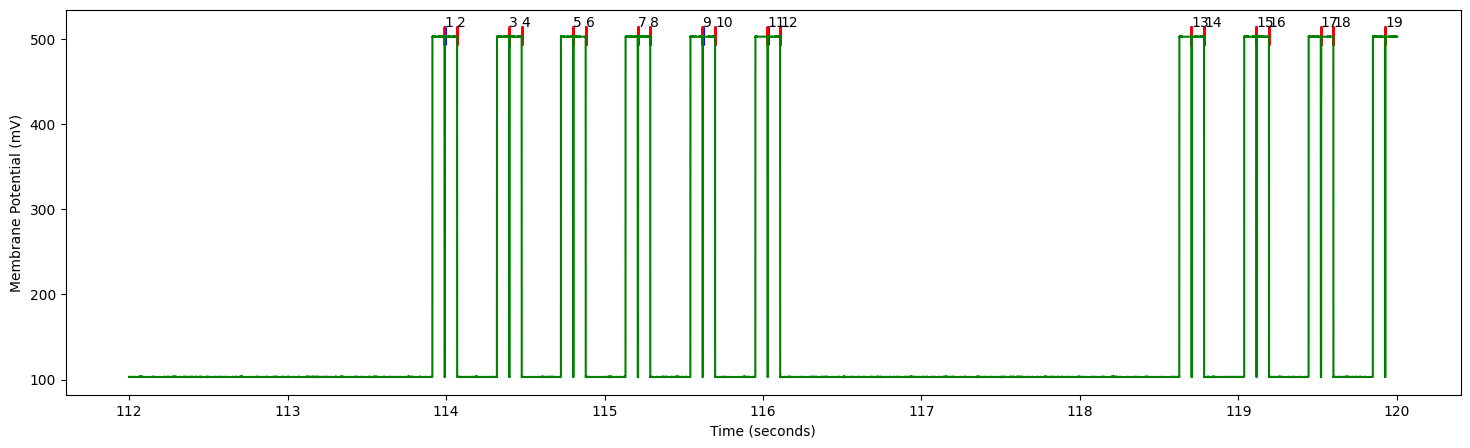

Time: 3000000 ~ 3200050
Close point found: 9
Far point found: 8


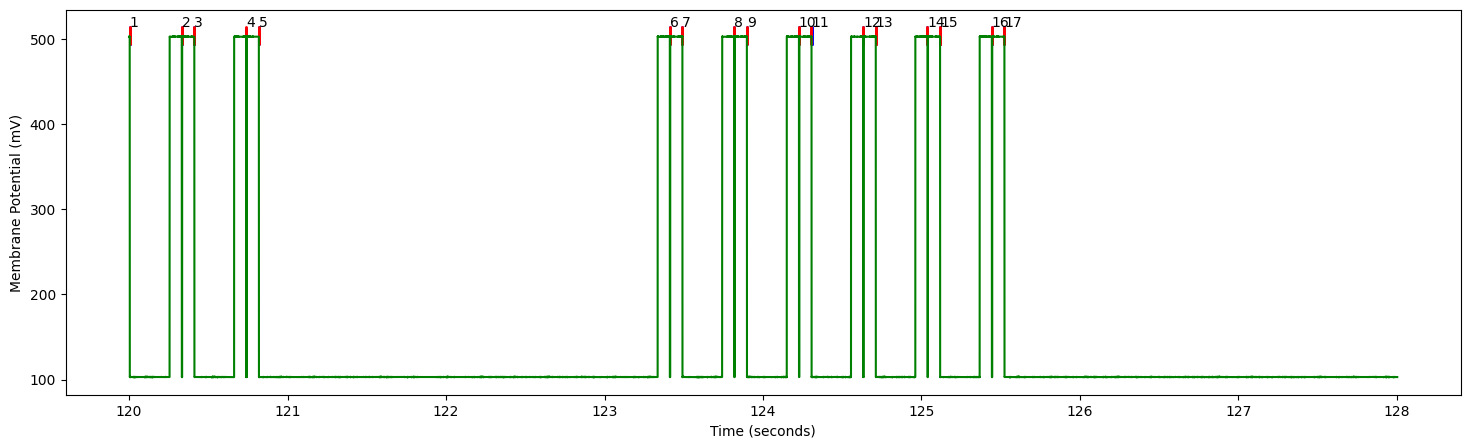

Time: 3200000 ~ 3400050
Close point found: 12
Far point found: 12


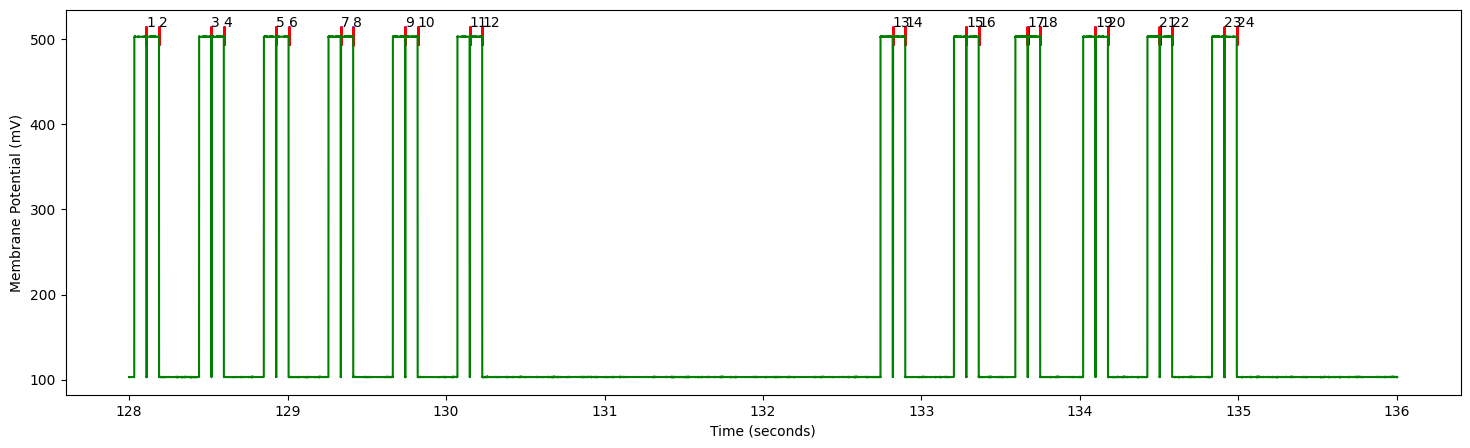

Time: 3400000 ~ 3600050
Close point found: 10
Far point found: 10


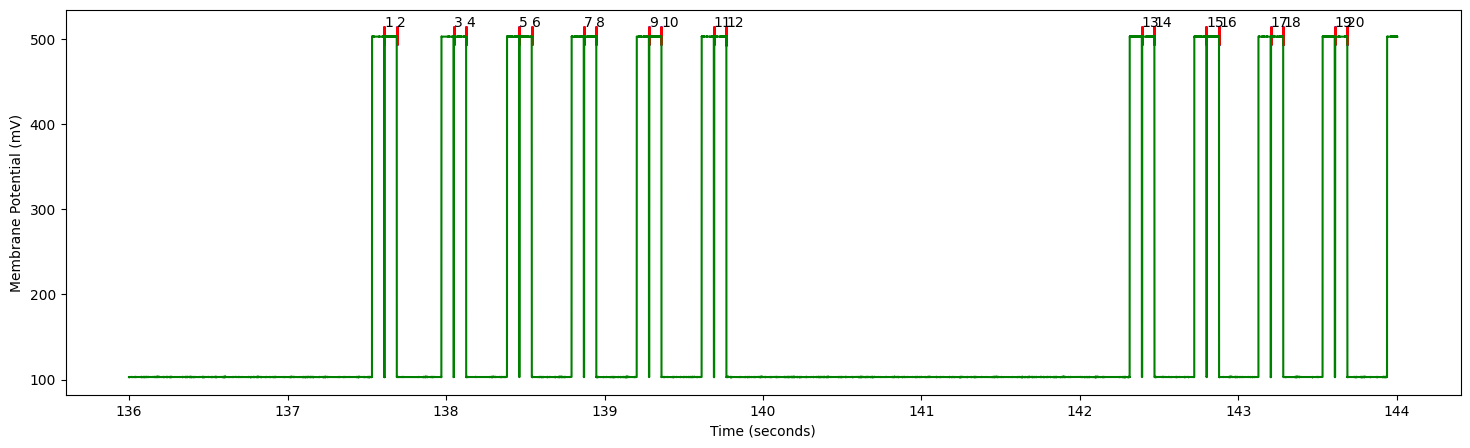

Time: 3600000 ~ 3800050
Close point found: 9
Far point found: 9


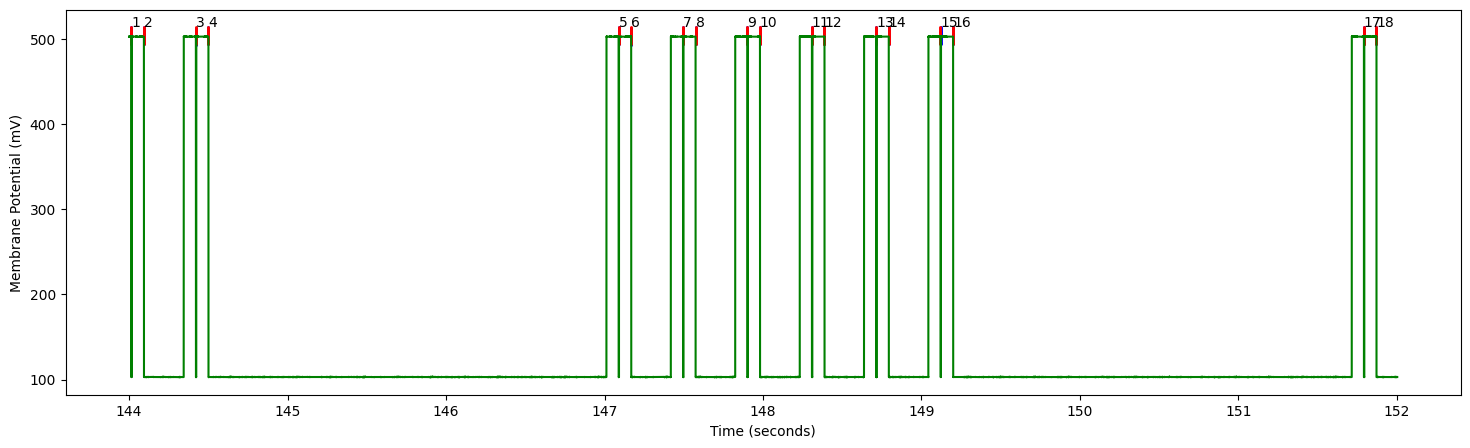

Time: 3800000 ~ 4000050
Close point found: 11
Far point found: 11


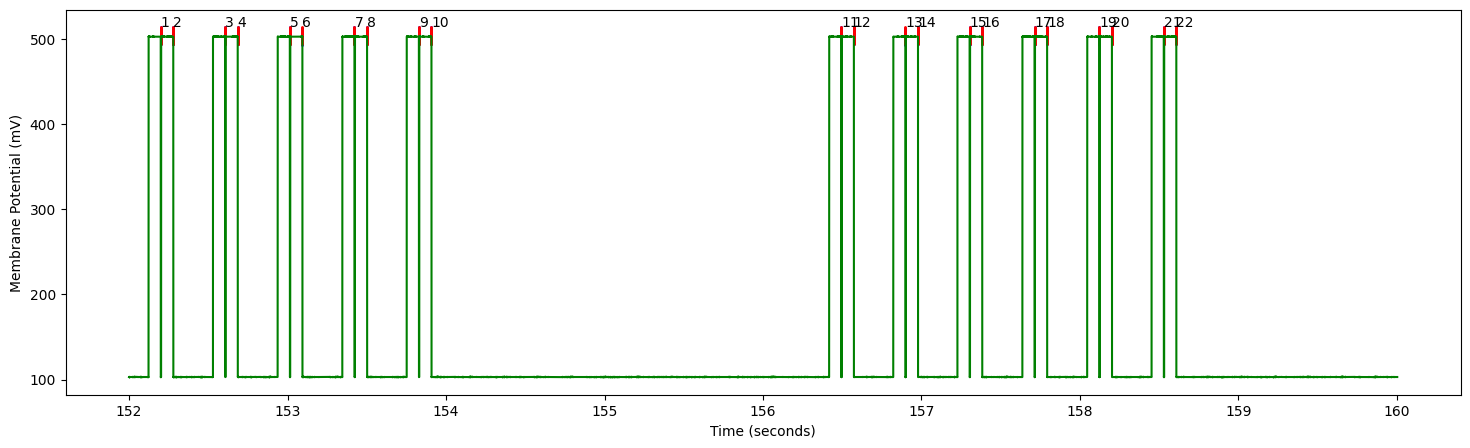

Time: 4000000 ~ 4200050
Close point found: 12
Far point found: 11


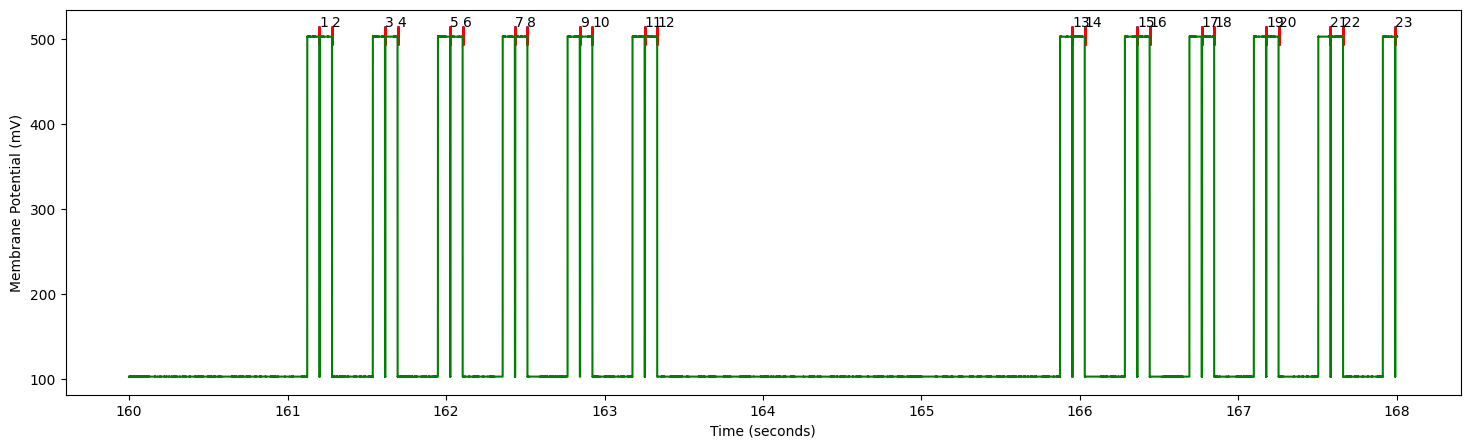

Time: 4200000 ~ 4400050
Close point found: 9
Far point found: 8


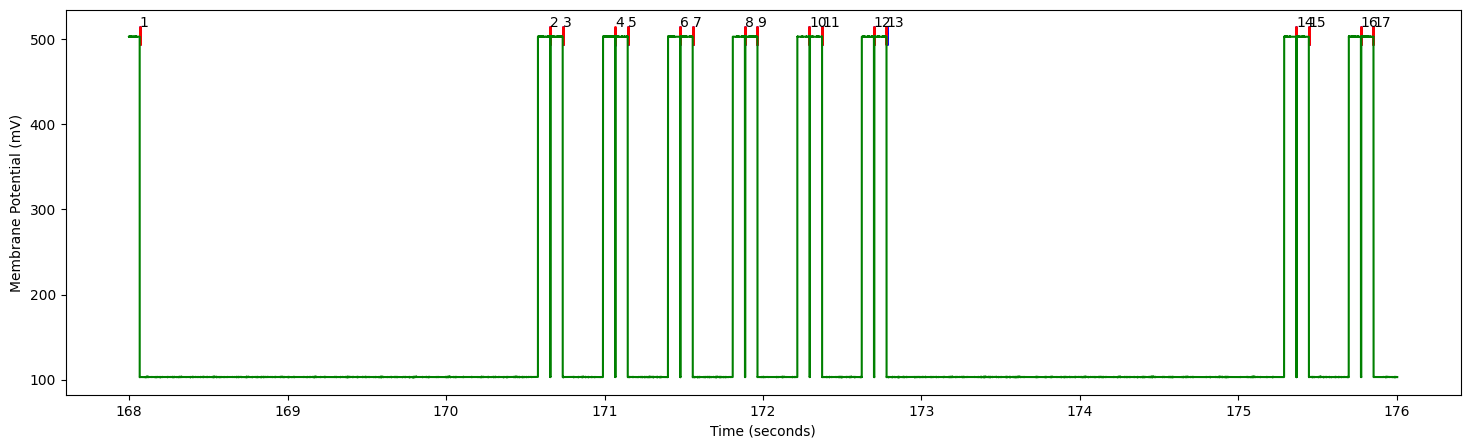

Time: 4400000 ~ 4600050
Close point found: 10
Far point found: 10


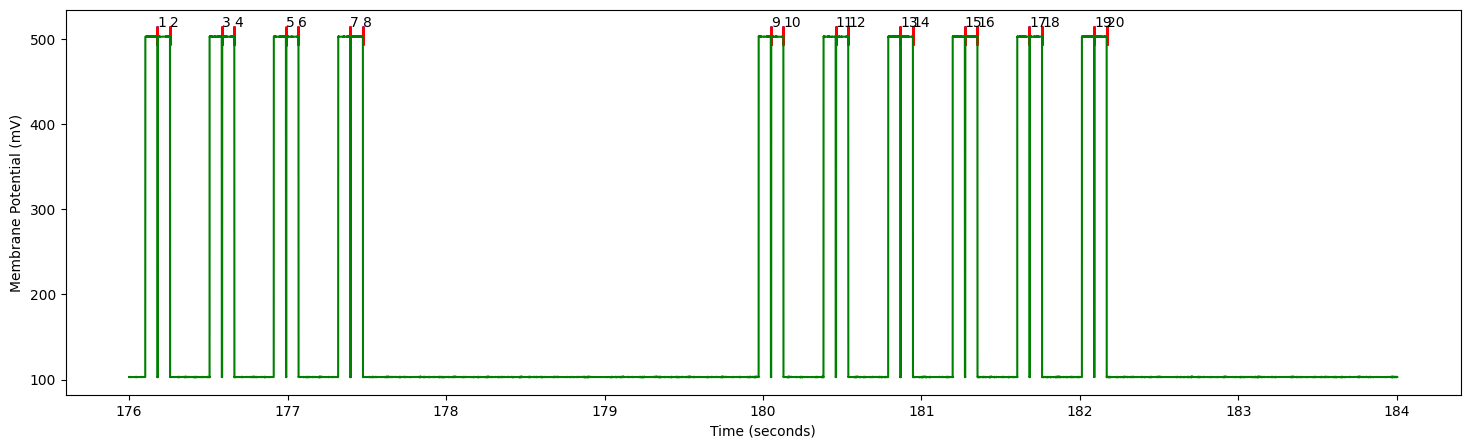

Time: 4600000 ~ 4800050
Close point found: 12
Far point found: 12


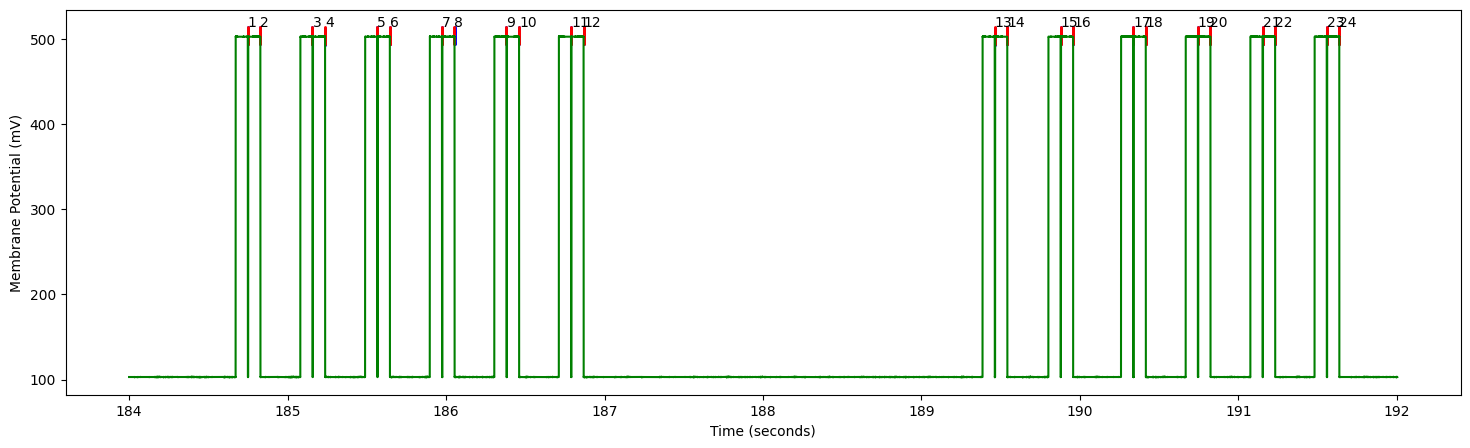

Time: 4800000 ~ 5000050
Close point found: 9
Far point found: 9


KeyboardInterrupt: 

In [49]:
interval = 200000
for i in range(0,len(abf.sweepY),interval):
    print("Time: %d ~ %d"%(i,i+interval+50))
    timeStart = i
    timeEnd = i+interval+50
    close_qty,far_qty = plot_v2(abf,volt,timeStart = timeStart, timeEnd = timeEnd,channel = 4)

## Test 03_v3--Check Total Points Collected in each (x,y)

In [15]:
print_points_qty(abf,end_index)

3  60 102 96 42 
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 17 6  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 17 6  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
15 17 16 7  
78 
Total points: [3, 60, 102, 96, 42, 15, 17, 16, 7, 15, 17, 16, 7, 15, 17, 16, 7, 15, 17, 16, 7, 15, 17, 16, 7, 15, 17, 16, 7, 15, 17, 16, 7, 15, 17, 16, 7, 15, 17, 16, 7, 15, 17, 16, 7, 15, 17, 16, 7, 15, 17, 16, 7, 15, 17, 16, 7, 15, 17, 16, 7, 15, 17, 16, 7, 15, 17, 16, 7, 15, 17, 16, 7, 15, 17, 16, 7, 15, 17, 16, 7, 15, 17, 16, 7, 15, 17,

C:\Users\caleb\anaconda3\envs\pytorch\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


# Start

##### V2: Include Bias
* 800mV 22214004.abf: 3120 + 4(start) + 3(end) = 3127
* 700mV 22214005.abf: 3120 + 6(start) = 3126
* 200mV 22318006.abf: 3120 + 5(start) = 3125
* 500mV 22304010.abf:
* 200mV 22323007.abf: 3120 + 
* 200mV 22504024.abf: 3120 + 12(start) = 3132
* 600mV 22519010.abf: 3120 + 3(start)= 3123 #Care for time: 36818519 36818524
### V1: Not include Bias

* 800mV 21n05000.abf: 3120 + 4(start) = 3124
* 700mV 21n05001.abf: 3120 + 4(start) + 41(end) = 3165 
* 600mV 21n05002.abf: 3120 + 4(start) = 3124
* 500mV 21n05003.abf: 3120 + 6(start) + 21(end) = 3147
* 400mV 21n05004.abf: Last point have only close, 3120+5(start)+1(end) = 3126
* 300mV 21n05005.abf: 3120 + 4(start) + 39(end) = 3163
* 600mV 21930014.abf: 3120 + 5(start)  = 3125
* 800mV 21d04000.abf: 3120 + 6(start) + 30(end) =3156

In [12]:
# v2
abfFile = "23428006.abf"
abf = pyabf.ABF("abf\\"+abfFile)

In [13]:
bins = 50
# start_ignore and end_ignore: extra points before reshape into rows
# start_extra and end_extra: extra points of each rows
start_ignore = 3 #Don't include the single point
end_ignore = 29 #Don't include the single point
pqty = 25
start_extra = 5
end_extra = 0
volt = 500
volt_cut = 300
title_prefix = str(volt)+"mV"
fig_save_path =getcwd()+"\\result\\"
Row = 50
Col = 50
start_single = True
end_single = True
emf_bias = 0
current_bias = 0

In [14]:
close,far,close_index,end_index = findStable_Bias(abf,volt_cut,start_single=start_single,end_single=end_single)

Close point found: 3076
Far point found: 3076


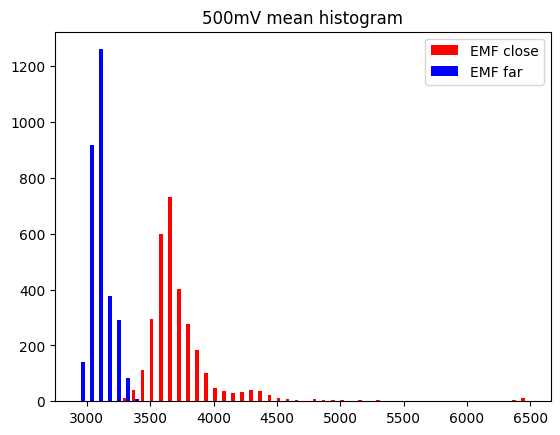

In [27]:
plt.figure()
plt.hist((close,far),bins=bins,label = ('EMF close','EMF far'),color = ('red','blue'))
plt.legend()
plt.title("%s mean histogram"%(title_prefix))
plt.savefig(fig_save_path+"%s mean histogram"%(title_prefix))
plt.show()

In [28]:
aut_close,quartz_close = separate(close,Row = Row, Col = Col,pqty = pqty,start_ignore = start_ignore, end_ignore = end_ignore, start_extra = start_extra, end_extra = end_extra,bias = emf_bias)
aut_far,quartz_far = separate(far,Row = Row, Col = Col,pqty = pqty,start_ignore = start_ignore, end_ignore = end_ignore,start_extra = start_extra, end_extra = end_extra,bias = emf_bias)

304 -29


ValueError: cannot reshape array of size 2743 into shape (49,55)

In [25]:
print("AUT Close:%.2f QUARTZ Close:%.2f"%(np.mean(aut_close),np.mean(quartz_close)))
print("AUT Far:%.2f QUARTZ Far:%.2f"%(np.mean(aut_far),np.mean(quartz_far)))

AUT Close:-897.07 QUARTZ Close:-915.70
AUT Far:-518.08 QUARTZ Far:-518.78


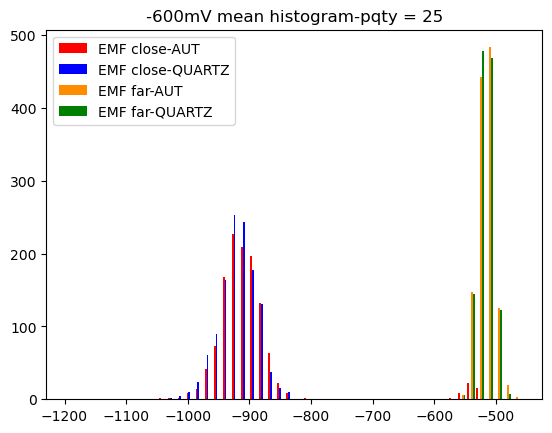

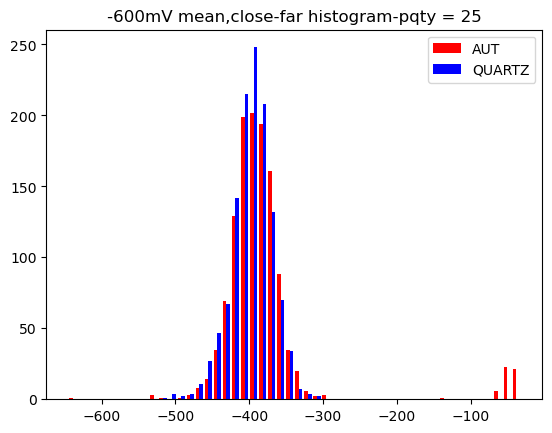

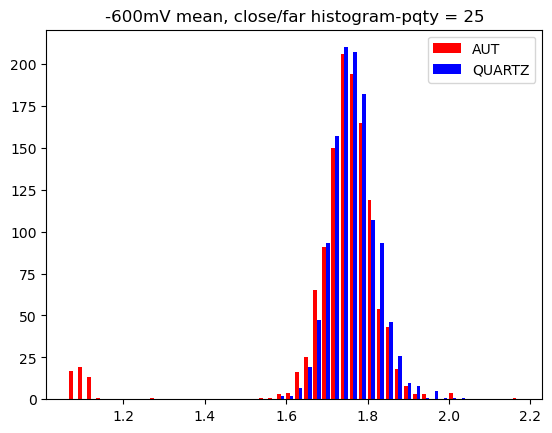

In [26]:
plt.figure()
plt.hist((aut_close,quartz_close,aut_far,quartz_far),bins=bins,label = ('EMF close-AUT','EMF close-QUARTZ','EMF far-AUT','EMF far-QUARTZ'),color = ('red','blue','darkorange','green'))
plt.legend()
plt.title("%s mean histogram-pqty = %d"%(title_prefix,pqty))
plt.savefig(fig_save_path+title_prefix+" mean histogram-pqty = "+str(pqty))
plt.show()

plt.figure()
plt.hist((aut_close-aut_far,quartz_close-quartz_far),bins=bins,label = ('AUT','QUARTZ'),color = ('red','blue'))
plt.legend()
plt.title("%s mean,close-far histogram-pqty = %d"%(title_prefix,pqty))
plt.savefig(fig_save_path+title_prefix + " mean,close-far histogram-pqty = "+str(pqty))
plt.show()

plt.figure()
plt.hist((aut_close/aut_far,quartz_close/quartz_far),bins=bins,label = ('AUT','QUARTZ'),color = ('red','blue'))
plt.legend()
plt.title("%s mean, close/far histogram-pqty = %d"%(title_prefix,pqty))
plt.savefig(fig_save_path+title_prefix + "close divide far histogram-pqty = "+str(pqty))
plt.show()

AUT: 1.730572 +- 0.666647
QUARTZ: 1.765490 +- 0.268216
50 49


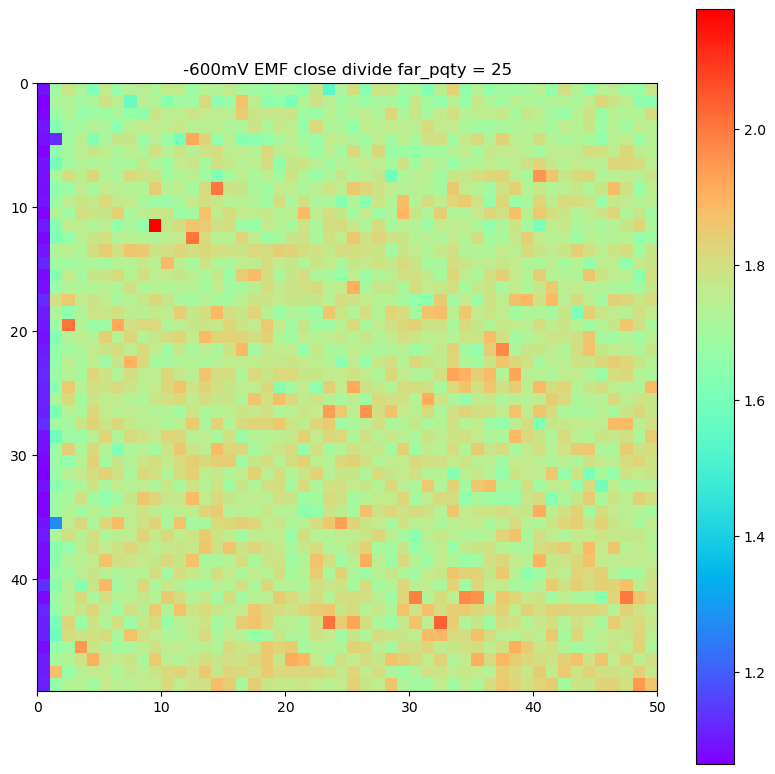

In [27]:
aut = aut_close/aut_far
quartz = quartz_close/quartz_far

a = aut
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("AUT: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))
a = quartz
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("QUARTZ: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))

aut = np.reshape(aut,(Row-1,pqty))
quartz = np.reshape(quartz,(Row-1,pqty))

EMF_normalized_data = np.hstack((aut,quartz))
plot_colormap(EMF_normalized_data,title = title_prefix + " EMF close divide far_pqty = "+str(pqty),path = fig_save_path)

AUT: -378.988610 +- 346.639977
QUARTZ: -396.918746 +- 123.528031
50 49


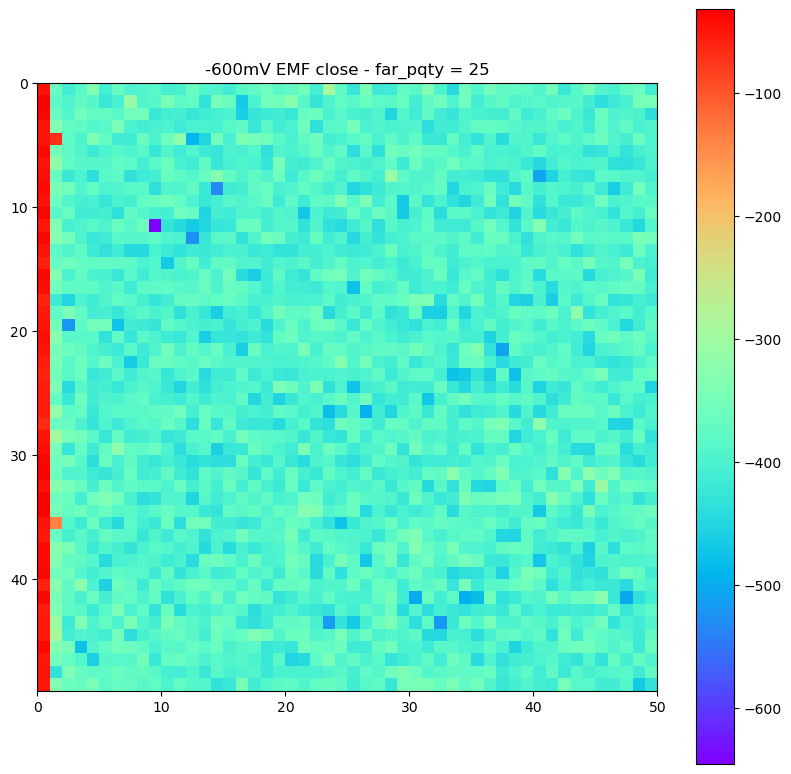

In [28]:
aut = aut_close-aut_far
quartz = quartz_close-quartz_far

a = aut
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("AUT: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))
a = quartz
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("QUARTZ: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))

aut = np.reshape(aut,(Row-1,pqty))
quartz = np.reshape(quartz,(Row-1,pqty))

EMF_normalized_data_subs = np.hstack((aut,quartz))
plot_colormap(EMF_normalized_data_subs,title = title_prefix + " EMF close - far_pqty = "+str(pqty),path = fig_save_path)

In [29]:
# Calculate on Current
I_close,I_far,_,_ = findStable_Bias(abf,volt_cut,start_single=start_single,end_single=end_single,channel = 0)

I_aut_close,I_quartz_close = separate(I_close,Row = Row, Col = Col,pqty = pqty,start_ignore = start_ignore, end_ignore = end_ignore, start_extra = start_extra, end_extra = end_extra,bias = current_bias)
I_aut_far,I_quartz_far = separate(I_far,Row = Row, Col = Col,pqty = pqty,start_ignore = start_ignore, end_ignore = end_ignore, start_extra = start_extra, end_extra = end_extra,bias = current_bias)

Close point found: 3028
Far point found: 3028
304 -29
304 -29


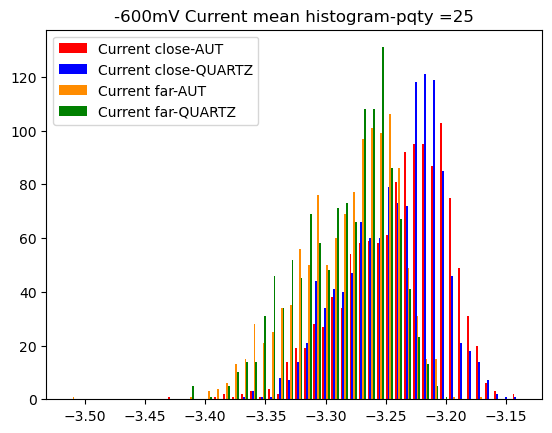

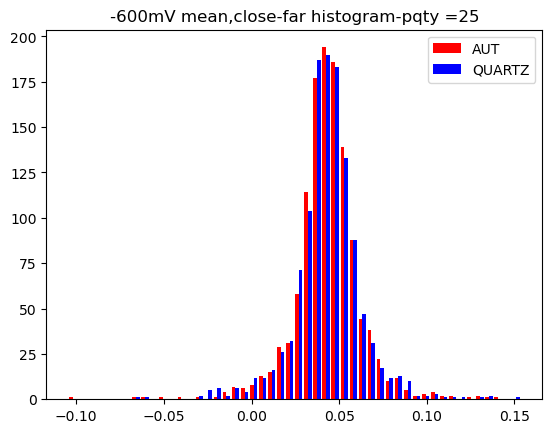

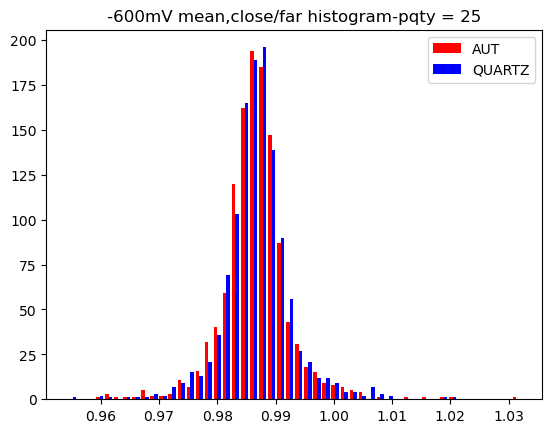

In [30]:
plt.figure()
plt.hist((I_aut_close,I_quartz_close,I_aut_far,I_quartz_far),bins=bins,label = ('Current close-AUT','Current close-QUARTZ','Current far-AUT','Current far-QUARTZ'),color = ('red','blue','darkorange','green'))
plt.legend()
plt.title(title_prefix + " Current mean histogram-pqty =" +str(pqty))
plt.savefig(fig_save_path+title_prefix + " Current mean histogram-pqty =" +str(pqty))
plt.show()

plt.figure()
plt.hist((I_aut_close-I_aut_far,I_quartz_close-I_quartz_far),bins=bins,label = ('AUT','QUARTZ'),color = ('red','blue'))
plt.legend()
plt.title(title_prefix + " mean,close-far histogram-pqty =" +str(pqty))
plt.savefig(fig_save_path+title_prefix + " mean,Current close-far histogram-pqty =" +str(pqty))
plt.show()

plt.figure()
plt.hist((I_aut_close/I_aut_far,I_quartz_close/I_quartz_far),bins=bins,label = ('AUT','QUARTZ'),color = ('red','blue'))
plt.legend()
plt.title(title_prefix + " mean,close/far histogram-pqty = "+str(pqty))
plt.savefig(fig_save_path+title_prefix + " mean,Current close divide far histogram-pqty =" +str(pqty))
plt.show()

In [31]:
I_aut = I_aut_close/I_aut_far
I_quartz = I_quartz_close/I_quartz_far

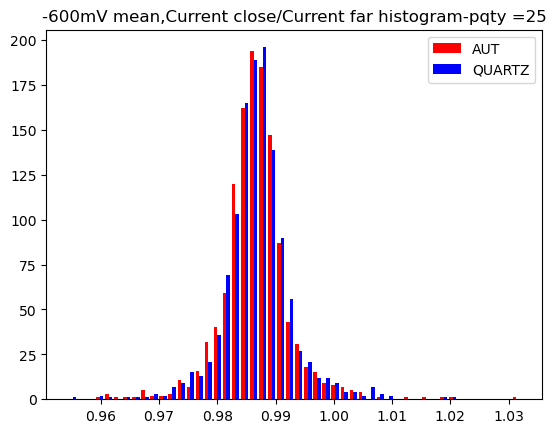

In [32]:
plt.figure()
plt.hist((I_aut,I_quartz),bins=bins,label = ('AUT','QUARTZ'),color = ('red','blue'))
plt.legend()
plt.title(title_prefix + " mean,Current close/Current far histogram-pqty =" +str(pqty))
plt.savefig(fig_save_path+title_prefix + " mean,Current close divide Current far histogram-pqty =" +str(pqty))
plt.show()

AUT: 0.986693 +- 0.045403
QUARTZ: 0.986869 +- 0.032911
50 49


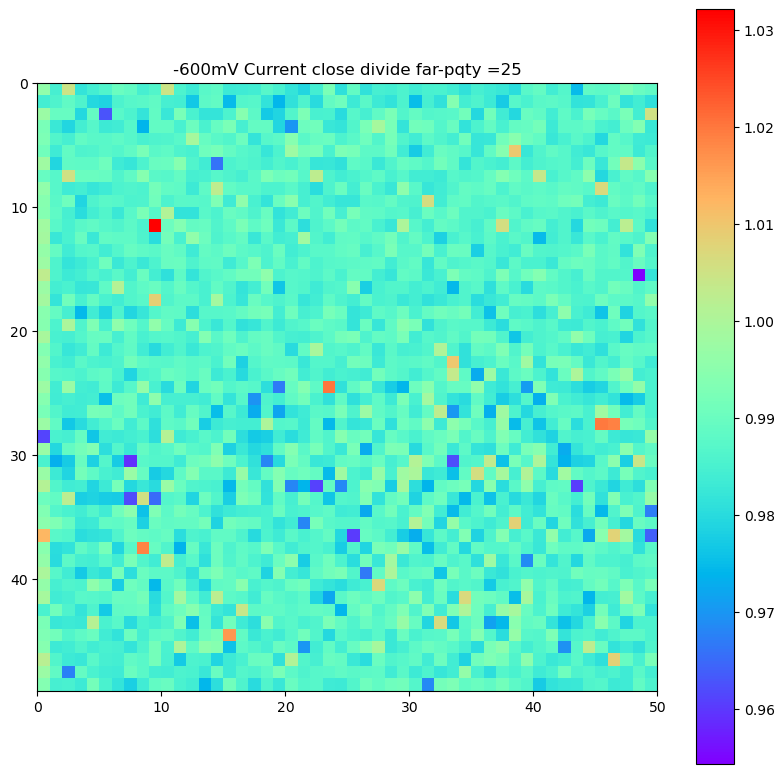

In [33]:
a = I_aut
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("AUT: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))
a = I_quartz
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("QUARTZ: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))

I_aut = np.reshape(I_aut,(Row-1,pqty))
I_quartz = np.reshape(I_quartz,(Row-1,pqty))

Current_normalized_data = np.hstack((I_aut,I_quartz))

plot_colormap(Current_normalized_data,title = title_prefix +  " Current close divide far-pqty =" +str(pqty),path = fig_save_path)

AUT: 0.043721 +- 0.148457
QUARTZ: 0.043185 +- 0.110440
50 49


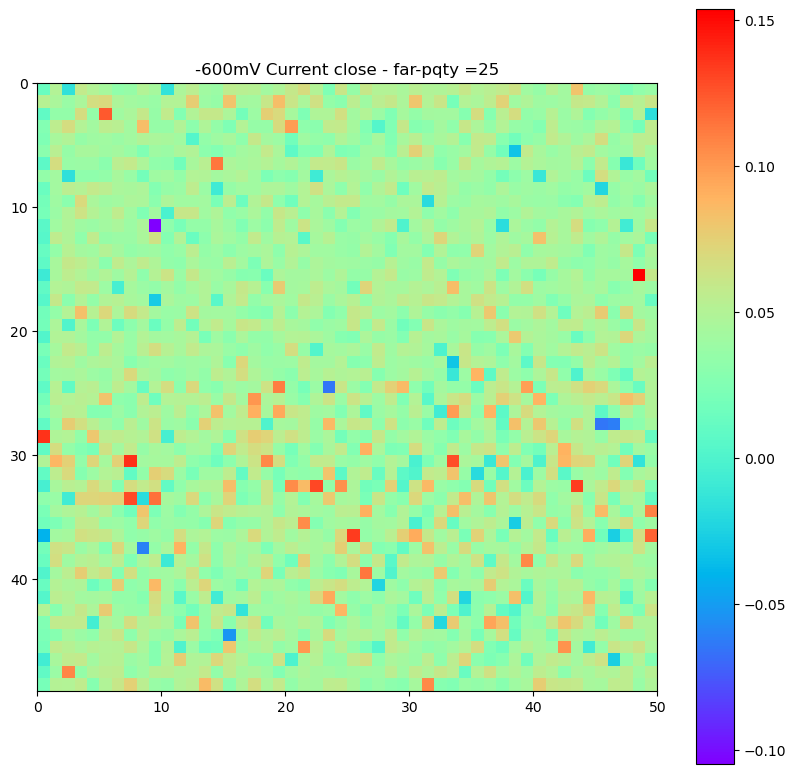

In [34]:
I_aut = I_aut_close-I_aut_far
I_quartz = I_quartz_close-I_quartz_far

a = I_aut
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("AUT: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))
a = I_quartz
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("QUARTZ: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))

I_aut = np.reshape(I_aut,(Row-1,pqty))
I_quartz = np.reshape(I_quartz,(Row-1,pqty))

Current_normalized_data_subs = np.hstack((I_aut,I_quartz))

plot_colormap(Current_normalized_data_subs,title = title_prefix +  " Current close - far-pqty =" +str(pqty),path = fig_save_path)


In [35]:
with open("result\\"+abfFile+'_current_div-pqty='+str(pqty)+'.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the data
    for row in Current_normalized_data:
        writer.writerow(row)

In [36]:
with open("result\\"+abfFile+'_current_subs-pqty='+str(pqty)+'.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the data
    for row in Current_normalized_data_subs:
        writer.writerow(row)

In [37]:
with open("result\\"+abfFile+'_EMF_div-pqty='+str(pqty)+'.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the data
    for row in EMF_normalized_data:
        writer.writerow(row)

In [38]:
with open("result\\"+abfFile+'_EMF_subs-pqty='+str(pqty)+'.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the data
    for row in EMF_normalized_data_subs:
        writer.writerow(row)

In [39]:
with open("result\\"+abfFile+'_EMF-pqty='+str(pqty)+'.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the data
    for w,x,y,z in zip(aut_close,aut_far,quartz_close,quartz_far):
        writer.writerow([w,x,y,z])

In [40]:
with open("result\\"+abfFile+'-pqty='+str(pqty)+'_current.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the data
    for w,x,y,z in zip(I_aut_close,I_aut_far,I_quartz_close,I_quartz_far):
        writer.writerow([w,x,y,z])

In [41]:
with open("result\\"+abfFile+'_EMF_close-pqty='+str(pqty)+'.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the data
    w_close = np.hstack((np.reshape(aut_close,(Row-1,int(Col/2))),np.reshape(quartz_close,(Row-1,int(Col/2)))))
    for x in w_close:
        writer.writerow(x)

In [42]:
with open("result\\"+abfFile+'_EMF_far-pqty='+str(pqty)+'.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the data
    w_far = np.hstack((np.reshape(aut_far,(Row-1,int(Col/2))),np.reshape(quartz_far,(Row-1,int(Col/2)))))
    for x in w_far:
        writer.writerow(x)